#Data Exploration & Visualisation

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
import pandas as pd

train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [ ]:
import pandas as pd

df = pd.read_csv("train.csv")
df = df[['text', 'target']]

print(df.shape)
print(df['target'].value_counts())


(7613, 2)
target
0    4342
1    3271
Name: count, dtype: int64


In [ ]:
for label in [0, 1]:
    print(f"\nClass {label} examples:")
    print(df[df['target'] == label]['text'].head(3).tolist())



Class 0 examples:
["What's up man?", 'I love fruits', 'Summer is lovely']

Class 1 examples:
['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all', 'Forest fire near La Ronge Sask. Canada', "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"]


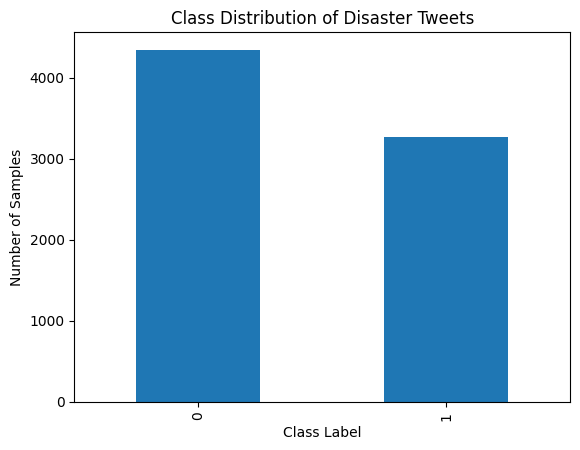

In [ ]:
import matplotlib.pyplot as plt

label_counts = df['target'].value_counts()

plt.figure()
label_counts.plot(kind='bar')
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution of Disaster Tweets")
plt.show()


#Text Pre-processing Pipeline

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Above Includes

Lowercasing

Regex cleaning

Tokenisation

Stop-word removal

Stemming or lemmatization

Example showing before and after

In [ ]:
sample = df['text'].iloc[0]
print("Before:", sample)
print("After :", preprocess(sample))


Before: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
After : deed reason earthquake may allah forgive u


lemmatization preserves meaning better than stemming


why?


Stemming removes word endings , often producing non-dictionary words f.g better into bet.While Lemmatization, on the other hand, reduces words to their base dictionary form using linguistic knowledge.F.g better into good.

#Feature Engineering

Bag-of-Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(ngram_range=(1,2), max_features=5000)
X_bow = bow.fit_transform(df['text'].apply(preprocess))

TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_tfidf = tfidf.fit_transform(df['text'].apply(preprocess))


Word2Vec

In [ ]:
from gensim.models import Word2Vec

sentences = [t.split() for t in df['text'].apply(preprocess)]

w2v = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)

ModuleNotFoundError: No module named 'gensim'

gensim was missing

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 70.3 MB/s eta 0:00:00


In [ ]:
from gensim.models import Word2Vec
import gensim
print(gensim.__version__)


4.4.0


Version checked

Word2Vec

In [ ]:
from gensim.models import Word2Vec

sentences = [t.split() for t in df['text'].apply(preprocess)]

w2v = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)

Convert sentence → vector (average)

In [ ]:
import numpy as np

def sentence_vector(sent):
    words = sent.split()
    vectors = [w2v.wv[w] for w in words if w in w2v.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

X_w2v = np.vstack(df['text'].apply(preprocess).apply(sentence_vector))


Word2Vec produces word-level embeddings, not sentence-level ones.
To represent a document, vectors are commonly averaged.

However, averaging:

treats all words as independent

ignores sequence and syntax

For praction

In [ ]:
import random
from collections import defaultdict

def build_markov(texts):
    model = defaultdict(list)
    for text in texts:
        words = text.split()
        for i in range(len(words)-1):
            model[words[i]].append(words[i+1])
    return model

def generate_sentence(model, start, length=10):
    word = start
    sentence = [word]
    for _ in range(length):
        word = random.choice(model[word])
        sentence.append(word)
    return " ".join(sentence)


Above Includes

Bag-of-Words

TF-IDF

Word2Vec (trained or pre-trained)

Sentence vector averaging

#Modelling & Evaluation

Train/validation/test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df['target'], test_size=0.2, random_state=42
)


Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.91      0.84       874
           1       0.84      0.66      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523



Logistic Regression --Discriminative

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.83      0.68      0.75       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



Logistic Regression on Word2Vec

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_w2v, df['target'], test_size=0.2, random_state=42
)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.59      0.98      0.73       874
           1       0.69      0.07      0.12       649

    accuracy                           0.59      1523
   macro avg       0.64      0.52      0.43      1523
weighted avg       0.63      0.59      0.47      1523



#Summary Table

In [ ]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Naïve Bayes", "Logistic Reg", "Logistic Reg"],
    "Features": ["BoW", "TF-IDF", "Word2Vec"],
    "Accuracy": [1523, 1523,1523],
    "Macro F1": [0.80, 0.80, 0.59]
})

results


,Model,Features,Accuracy,Macro F1
0,Naïve Bayes,BoW,1523,0.80
1,Logistic Reg,TF-IDF,1523,0.80
2,Logistic Reg,Word2Vec,1523,0.59


#Analysis & Discussion

Generative vs Discriminative Models


Naïve Bayes is computationally efficient and simple, making it suitable for large-scale text classification. However, it relies on strong independence assumptions. Logistic Regression directly models the decision boundary between classes and therefore achieves better performance when sufficient training data is available.

TF-IDF vs Word2Vec

TF-IDF emphasizes informative terms by down-weighting common words, which improves classification accuracy. Word2Vec captures semantic similarity between words, allowing the model to generalize better across vocabulary .However, sparse representations remain more interpretable, as feature weights directly correspond to words